# BSPF Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import obspy as obs
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [2]:
from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
from functions.compute_linear_regression import __compute_linear_regression

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [4]:
config = {}

config['path_to_data'] = data_path+"BSPF/data/"

config['path_to_catalogs'] = data_path+"BSPF/data/catalogs/"

config['catalog'] = ""

## Load Data

In [5]:
data_amax_disp = pd.read_pickle(config['path_to_data']+"bspf_analysisdata_amax_disp.pkl")

data_snr = pd.read_pickle(config['path_to_data']+"bspf_analysisdata_snr_disp.pkl")


## Modify Data

Filter data

In [6]:
## reject nan values
print(f" AMAX:  all: {data_amax_disp.origin.size} no_nan: {data_amax_disp.dropna().shape[0]}")
data_amax_disp.dropna(inplace=True)

print(f" SNR:  all: {data_snr.origin.size} no_nan: {data_snr.dropna().shape[0]}")
data_snr.dropna(inplace=True)

 AMAX:  all: 282 no_nan: 180
 SNR:  all: 282 no_nan: 278


In [7]:
## reject all magnitude types not ml
nn = [mm for mm in data_amax_disp.Mag_type if mm != "ml"]

data_amax_disp = data_amax_disp[data_amax_disp.Mag_type == "ml"]
data_snr = data_snr[data_snr.Mag_type == "ml"]

print(f"\n -> rejected {len(nn)} events: {nn}")


 -> rejected 6 events: ['mlr', 'mw', 'mw', 'mw', 'mw', 'mlr']


In [8]:
data_amax_disp_cosum_6 = data_amax_disp[data_amax_disp.CoincidenceSum == 6]

data_snr_cosum_6 = data_snr[data_snr.CoincidenceSum == 6]


In [9]:
data_snr_cosum_6.shape, data_amax_disp_cosum_6.shape

((143, 24), (89, 24))

## Plots

In [10]:
def __makeplot(data1, data2, data3, data4):

    import matplotlib

    fig, ax = plt.subplots(1,1,figsize=(15,5))

    font=14

    cmap = plt.get_cmap("viridis", 9)

    # dat = np.log10(data4.BSPF__N_snr)
    dat = np.log10(data4.PFO_10_Z_snr)


    ax.scatter(data1.Hdistance_km, data1.Magnitude, s=30, color="grey", zorder=1, label=f"all (N={len(data1)})")

    cax = ax.scatter(data2.Hdistance_km, data2.Magnitude, s=50, lw=0.5, edgecolors="k",
                     c=dat, cmap=cmap, zorder=2, label=f"CoSum6 (N={len(data2)})", vmin=round(min(dat),1), vmax=4.5)

    ax.grid(ls="--", color="grey", alpha=0.6, zorder=0,which="both")
    ax.legend(loc=4, fontsize=font)

    ax.set_ylabel("Magnitude", fontsize=font)
    ax.set_xlabel("Hypocenter Distance (km)", fontsize=font)

    ax.set_xscale("log")
    ax.set_xlim(left=10)

    cbar = plt.colorbar(cax, pad=0.02)
    cbar.set_label(r"log$_{10}$(signal-to-noise ratio)", fontsize=font)
#     cbar.set_clim(0,4)

    ax.set_xticks([10, 20, 30, 40, 50, 100])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    plt.show()

# __makeplot(data_amax_disp, data_amax_disp_cosum_6, data_snr, data_snr_cosum_6)

## Magnitude Scale 

$M_L = log_{10} (A_{max}) + 1.11 log_{10} (R) + 0.00189 R - 2.09$   (adopted local magnitude scale)

with $R$ = hypocentral distance in km and $A_{max}$ = maximal amplitude in nm

In [11]:
def __ml(amax, hdist):
    return np.log10(amax) + 1.11*np.log10(hdist) + 0.00189*hdist -2.09

In [12]:

## reject nan values
print(f" AMAX:  all: {data_amax_disp.origin.size} no_nan: {data_amax_disp.dropna().shape[0]}")
data_amax_disp.dropna(inplace=True)

## reject all magnitude types not ml
nn = [mm for mm in data_amax_disp.Mag_type if mm != "ml"]
data_amax_disp = data_amax_disp[data_amax_disp.Mag_type == "ml"]
print(f"\n -> rejected {len(nn)} events: {nn}")

 AMAX:  all: 174 no_nan: 174

 -> rejected 0 events: []


In [13]:
mm_z = __ml(data_amax_disp.PFO_10_Z_amax*1e6, data_amax_disp.Hdistance_km)
mm_n = __ml(data_amax_disp.PFO_10_N_amax*1e6, data_amax_disp.Hdistance_km)
mm_e = __ml(data_amax_disp.PFO_10_E_amax*1e6, data_amax_disp.Hdistance_km)

mm_t = __ml(data_amax_disp.PFO_10_T_amax*1e6, data_amax_disp.Hdistance_km)
mm_r = __ml(data_amax_disp.PFO_10_R_amax*1e6, data_amax_disp.Hdistance_km)


In [14]:
def __makeplot_magnitude_comparison():

    fig, ax = plt.subplots(1,3, figsize=(15,4))

    ax[0].scatter(hdist, mm, color='k', zorder=3)
    ax[0].scatter(hdist, mm_z, s=15, zorder=3, label="Z", edgecolors="tab:orange", color="tab:orange", alpha=0.7)
    ax[0].scatter(hdist, mm_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.7)
    ax[0].scatter(hdist, mm_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.7)

    ax[0].grid(zorder=0, alpha=0.4)
    ax[0].legend(loc=4)

    ax[0].set_xlabel(r"log$_{10}$( Hypocentral Distance ) (km)")
    ax[0].set_ylabel("Magnitude")

    dbars = 0.5
    bars = np.arange(0,5+dbars,dbars)

    # labels, counts = np.unique(mm, return_counts=True)
    # ax[1].bar(labels, counts, align='center', width=0.5)

    ax[1].hist(mm, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="k", rwidth=0.9, fill=False, align="mid")
    ax[1].hist(mm_z, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:orange", edgecolor="tab:orange", rwidth=0.7, fill=False, align="mid", label="Z")
    ax[1].hist(mm_n, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:blue", edgecolor="tab:blue", rwidth=0.5, fill=False, align="mid", label="N")
    ax[1].hist(mm_e, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:green", edgecolor="tab:green", rwidth=0.3, fill=False, align="mid", label="E")
    ax[1].set_xticks(bars)
    # ax[1].set_xticks(bars+dbars/2)
    # ax[1].set_xticklabels([f"{b}-{b+dbars}" for b in bars], rotation=60)

    ax[1].legend(loc=1)
    ax[1].grid(zorder=0, alpha=0.4)

    ax[1].set_xlabel(r"M$_L$")
    ax[1].set_ylabel("Total Number")

    lim = round(max(max(abs(diff_z)), max(abs(diff_n)), max(abs(diff_e))),1)
    dbars2 = 0.2
    bars2 = np.arange(-lim, lim+dbars2, dbars2)
    ax[2].hist(diff_z, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:orange", edgecolor="tab:orange", rwidth=1, fill=False, align="mid", label="Z")
    ax[2].hist(diff_n, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:blue", edgecolor="tab:blue", rwidth=1, fill=False, align="mid", label="N")
    ax[2].hist(diff_e, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:green", edgecolor="tab:green", rwidth=1, fill=False, align="mid", label="E")

    ax[2].legend(loc=1)
    ax[2].grid(zorder=0, alpha=0.4)

    ax[2].set_xlabel(r"M$_L$ - M$_{L, est.}$")
    ax[2].set_ylabel("Total Number")

    plt.show();

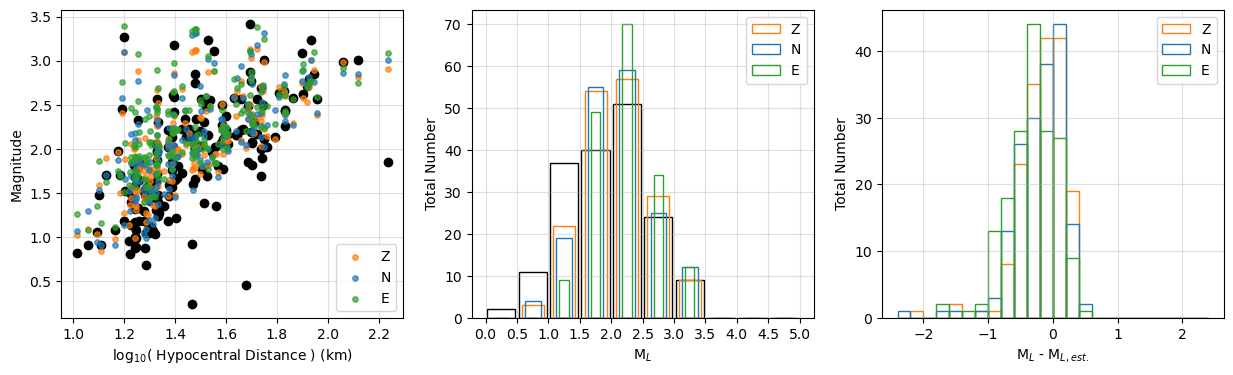

In [15]:
x_events = range(len(data_amax_disp))

hdist = np.log10(data_amax_disp.Hdistance_km)

mm = data_amax_disp.Magnitude

diff_z, diff_n, diff_e = mm-mm_z, mm-mm_n, mm-mm_e

__makeplot_magnitude_comparison()

## Fitting Translation Data

In [78]:
def __ml_fit(X, a, b ,c):
    amax, hdist = X
    return np.log10(amax) + a*np.log10(hdist) + b*hdist - c

In [81]:
def __predict_local_amplitude_ml(X):
    mag, hdist = X
    return 10**( mag - 1.11*np.log10(hdist) - 0.00189*hdist +  2.09)

In [79]:
def __predict_local_amplitude(X, a, b ,c):
    mag, hdist = X
    return 10**( mag - a*np.log10(hdist) - b*hdist + c )

In [97]:
## select amplitude data
amax_n = data_amax_disp_cosum_6.PFO_10_N_amax*1e9
amax_e = data_amax_disp_cosum_6.PFO_10_E_amax*1e9

## select hypocentral distances and magnitudes
hdist = data_amax_disp_cosum_6.Hdistance_km
mag = data_amax_disp_cosum_6.Magnitude

## perform data fitting
popt_n, pcov_n = curve_fit(__ml_fit, (amax_n, hdist), mag, p0=(1., 0.001, 2.))
popt_e, pcov_e = curve_fit(__ml_fit, (amax_e, hdist), mag, p0=(1., 0.001, 2.))

## output the new laws
print(f"\n N_trans:   Ml = log10(Amax) + {popt_n[0]:.2f} log10(R) + {popt_n[1]:.5f} R + {popt_n[2]:.2f}")
print(f"\n E_trans:   Ml = log10(Amax) + {popt_e[0]:.2f} log10(R) + {popt_e[1]:.5f} R + {popt_e[2]:.2f}")

## generate synthetic magnitudes
syn_data_e = __ml_fit((amax_e, hdist), popt_e[0], popt_e[1], popt_e[2])
syn_data_n = __ml_fit((amax_n, hdist), popt_n[0], popt_n[1], popt_n[2])

## compute differences of magnitudes and synthetics
diff_syn_n = mag-syn_data_n
diff_syn_e = mag-syn_data_e

## compute synthetic maximal amplitudes
amax_syn = __predict_local_amplitude_ml((mag, hdist))
amax_syn_n = __predict_local_amplitude((mag, hdist), popt_n[0], popt_n[1], popt_n[2])
amax_syn_e = __predict_local_amplitude((mag, hdist), popt_e[0], popt_e[1], popt_e[2])


 N_trans:   Ml = log10(Amax) + 1.23 log10(R) + 0.00480 R + 5.56

 E_trans:   Ml = log10(Amax) + 1.67 log10(R) + 0.00420 R + 6.32


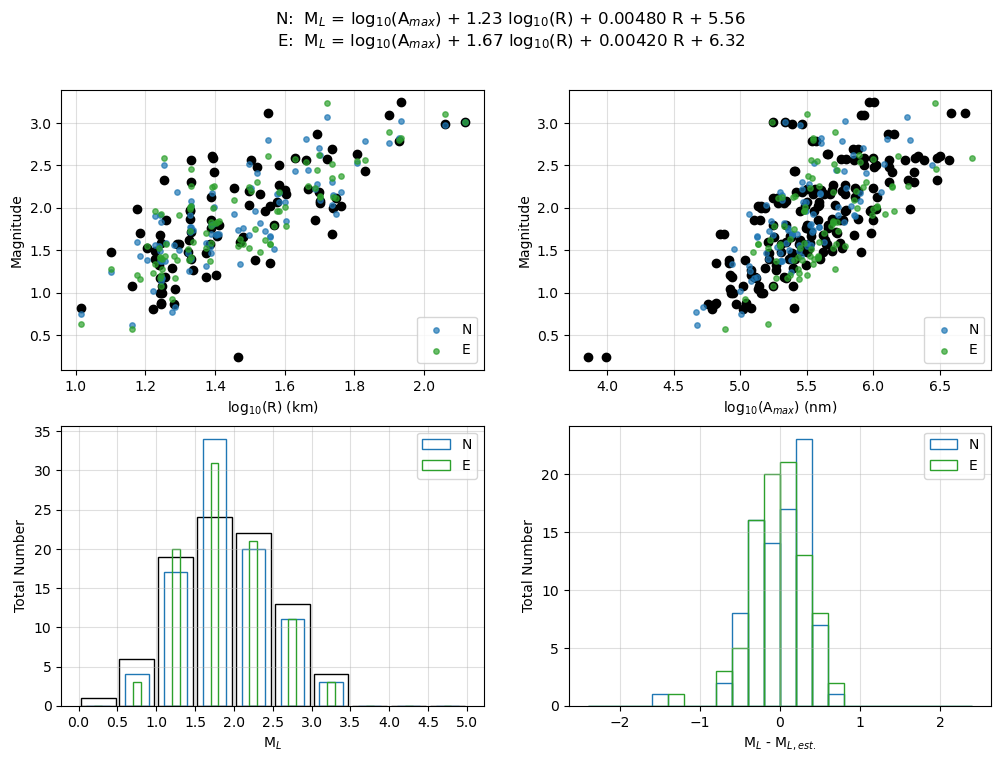

In [98]:
def __makeplot_magnitude_comparison2():

    fig, ax = plt.subplots(2,2, figsize=(12,8))

    ## ______________________________________________________________

    ax[0,0].scatter(np.log10(hdist), mag, color='k', zorder=3)
    ax[0,0].scatter(np.log10(hdist), syn_data_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.7)
    ax[0,0].scatter(np.log10(hdist), syn_data_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.7)

    ax[0,0].grid(zorder=0, alpha=0.4)
    ax[0,0].legend(loc=4)

    ax[0,0].set_xlabel(r"log$_{10}$(R) (km)")
    ax[0,0].set_ylabel("Magnitude")


    ## ______________________________________________________________

    ax[0,1].scatter(np.log10(amax_syn_n), mag, color='k', zorder=3)
    ax[0,1].scatter(np.log10(amax_syn_e), mag, color='k', zorder=3)

    ax[0,1].scatter(np.log10(amax_n), syn_data_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.7)
    ax[0,1].scatter(np.log10(amax_e), syn_data_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.7)

    ax[0,1].grid(zorder=0, alpha=0.4)
    ax[0,1].legend(loc=4)

    ax[0,1].set_xlabel(r"log$_{10}$(A$_{max}$) (nm)")
    ax[0,1].set_ylabel("Magnitude")


    ## ______________________________________________________________

    dbars = 0.5
    bars = np.arange(0,5+dbars,dbars)

    # labels, counts = np.unique(mag, return_counts=True)
    # ax[1].bar(labels, counts, align='center', width=0.5)

    ax[1,0].hist(mag, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="k", rwidth=0.9, fill=False, align="mid")
    # ax[1,1].hist(mag_z, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               # color="tab:orange", edgecolor="tab:orange", rwidth=0.7, fill=False, align="mid", label="Z")
    ax[1,0].hist(syn_data_n, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:blue", edgecolor="tab:blue", rwidth=0.6, fill=False, align="mid", label="N")
    ax[1,0].hist(syn_data_e, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:green", edgecolor="tab:green", rwidth=0.2, fill=False, align="mid", label="E")
    ax[1,0].set_xticks(bars)

    ax[1,0].legend(loc=1)
    ax[1,0].grid(zorder=0, alpha=0.4)

    ax[1,0].set_xlabel(r"M$_L$")
    ax[1,0].set_ylabel("Total Number")


    ## ______________________________________________________________


    lim = round(max(max(abs(diff_z)), max(abs(diff_n)), max(abs(diff_e))),1)
    dbars2 = 0.2
    bars2 = np.arange(-lim, lim+dbars2, dbars2)

    # ax[2].hist(diff_z, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
    #            color="tab:orange", edgecolor="tab:orange", rwidth=1, fill=False, align="mid", label="Z")
    ax[1,1].hist(diff_syn_n, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:blue", edgecolor="tab:blue", rwidth=1, fill=False, align="mid", label="N")
    ax[1,1].hist(diff_syn_e, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:green", edgecolor="tab:green", rwidth=1, fill=False, align="mid", label="E")

    ax[1,1].legend(loc=1)
    ax[1,1].grid(zorder=0, alpha=0.4)

    ax[1,1].set_xlabel(r"M$_L$ - M$_{L, est.}$")
    ax[1,1].set_ylabel("Total Number")



    ml_str, log10_str, amax_str = r"M$_L$", r"log$_{10}$", r"A$_{max}$"
    law1 = f"{ml_str} = {log10_str}({amax_str}) + {popt_n[0]:.2f} {log10_str}(R) + {popt_n[1]:.5f} R + {popt_n[2]:.2f}"
    law2 = f"{ml_str} = {log10_str}({amax_str}) + {popt_e[0]:.2f} {log10_str}(R) + {popt_e[1]:.5f} R + {popt_e[2]:.2f}"
    plt.suptitle(f" N:  {law1}  \nE:  {law2}")

    plt.show();

__makeplot_magnitude_comparison2()

## Fitting Rotation Data

In [94]:
## select amplitude data
amax_n = data_amax_disp_cosum_6.BSPF__N_amax
amax_e = data_amax_disp_cosum_6.BSPF__E_amax

## select hypocentral distances and magnitudes
hdist = data_amax_disp_cosum_6.Hdistance_km
mag = data_amax_disp_cosum_6.Magnitude

## perform data fitting
popt_n, pcov_n = curve_fit(__ml_fit, (amax_n, hdist), mag, p0=(1., 0.001, 2.))
popt_e, pcov_e = curve_fit(__ml_fit, (amax_e, hdist), mag, p0=(1., 0.001, 2.))

## output the new laws
print(f"\n N_rot:   Ml = log10(Amax) + {popt_n[0]:.2f} log10(R) + {popt_n[1]:.5f} R + {popt_n[2]:.2f}")
print(f"\n E_rot:   Ml = log10(Amax) + {popt_e[0]:.2f} log10(R) + {popt_e[1]:.5f} R + {popt_e[2]:.2f}")

## generate synthetic magnitudes
syn_data_e = __ml_fit((amax_e, hdist), popt_e[0], popt_e[1], popt_e[2])
syn_data_n = __ml_fit((amax_n, hdist), popt_n[0], popt_n[1], popt_n[2])

## compute differences of magnitudes and synthetics
diff_syn_n = mag-syn_data_n
diff_syn_e = mag-syn_data_e


## compute synthetic maximal amplitudes
amax_syn = __predict_local_amplitude_ml((mag, hdist))
amax_syn_n = __predict_local_amplitude((mag, hdist), popt_n[0], popt_n[1], popt_n[2])
amax_syn_e = __predict_local_amplitude((mag, hdist), popt_e[0], popt_e[1], popt_e[2])


 N_rot:   Ml = log10(Amax) + 2.08 log10(R) + 0.00175 R + -4.70

 E_rot:   Ml = log10(Amax) + 1.74 log10(R) + 0.00283 R + -5.39


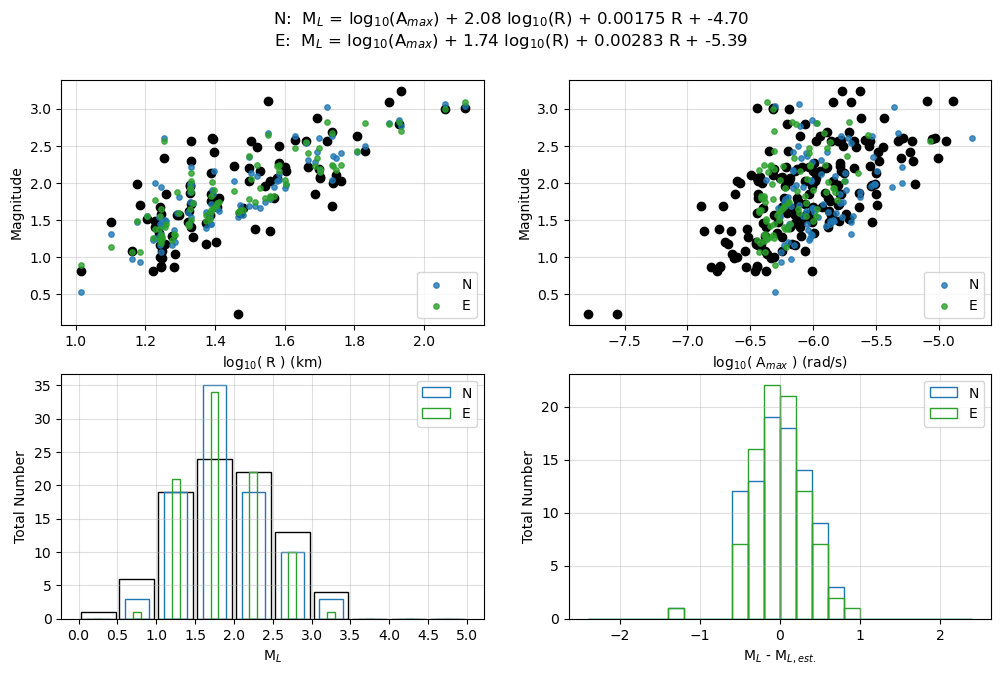

In [95]:
def __makeplot_magnitude_comparison3():

    fig, ax = plt.subplots(2,2, figsize=(12,7))

    ## ______________________________________________________________

    ax[0,0].scatter(np.log10(hdist), mag, zorder=3, color="black")
    ax[0,0].scatter(np.log10(hdist), syn_data_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.8)
    ax[0,0].scatter(np.log10(hdist), syn_data_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.8)

    ax[0,0].grid(zorder=0, alpha=0.4)
    ax[0,0].legend(loc=4)

    ax[0,0].set_xlabel(r"log$_{10}$( R ) (km)")
    ax[0,0].set_ylabel("Magnitude")


    ## ______________________________________________________________

    ax[0,1].scatter(np.log10(amax_syn_n), mag, color='k', zorder=3)
    ax[0,1].scatter(np.log10(amax_syn_e), mag, color='k', zorder=3)

    ax[0,1].scatter(np.log10(amax_n), syn_data_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.8)
    ax[0,1].scatter(np.log10(amax_e), syn_data_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.8)

    ax[0,1].grid(zorder=0, alpha=0.4)
    ax[0,1].legend(loc=4)

    ax[0,1].set_xlabel(r"log$_{10}$( A$_{max}$ ) (rad/s)")
    ax[0,1].set_ylabel("Magnitude")


    ## ______________________________________________________________

    dbars = 0.5
    bars = np.arange(0,5+dbars,dbars)

    # labels, counts = np.unique(mag, return_counts=True)
    # ax[1].bar(labels, counts, align='center', width=0.5)

    ax[1,0].hist(mag, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="k", rwidth=0.9, fill=False, align="mid")
    # ax[1,0].hist(mag_z, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               # color="tab:orange", edgecolor="tab:orange", rwidth=0.7, fill=False, align="mid", label="Z")
    ax[1,0].hist(syn_data_n, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:blue", edgecolor="tab:blue", rwidth=0.6, fill=False, align="mid", label="N")
    ax[1,0].hist(syn_data_e, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:green", edgecolor="tab:green", rwidth=0.2, fill=False, align="mid", label="E")
    ax[1,0].set_xticks(bars)
    # ax[1,0].set_xticks(bars+dbars/2)
    # ax[1,0].set_xticklabels([f"{b}-{b+dbars}" for b in bars], rotation=60)

    ax[1,0].legend(loc=1)
    ax[1,0].grid(zorder=0, alpha=0.4)

    ax[1,0].set_xlabel(r"M$_L$")
    ax[1,0].set_ylabel("Total Number")


    ## ______________________________________________________________

    lim = round(max(max(abs(diff_z)), max(abs(diff_n)), max(abs(diff_e))),1)
    dbars2 = 0.2
    bars2 = np.arange(-lim, lim+dbars2, dbars2)
    # ax[1,1].hist(diff_z, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
    #            color="tab:orange", edgecolor="tab:orange", rwidth=1, fill=False, align="mid", label="Z")
    ax[1,1].hist(diff_syn_n, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:blue", edgecolor="tab:blue", rwidth=1, fill=False, align="mid", label="N")
    ax[1,1].hist(diff_syn_e, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:green", edgecolor="tab:green", rwidth=1, fill=False, align="mid", label="E")

    ax[1,1].legend(loc=1)
    ax[1,1].grid(zorder=0, alpha=0.4)

    ax[1,1].set_xlabel(r"M$_L$ - M$_{L, est.}$")
    ax[1,1].set_ylabel("Total Number")


    ml_str, log10_str, amax_str = r"M$_L$", r"log$_{10}$", r"A$_{max}$"
    law1 = f"{ml_str} = {log10_str}({amax_str}) + {popt_n[0]:.2f} {log10_str}(R) + {popt_n[1]:.5f} R + {popt_n[2]:.2f}"
    law2 = f"{ml_str} = {log10_str}({amax_str}) + {popt_e[0]:.2f} {log10_str}(R) + {popt_e[1]:.5f} R + {popt_e[2]:.2f}"
    plt.suptitle(f" N:  {law1}  \nE:  {law2}")

    plt.show();

__makeplot_magnitude_comparison3()

## Test 

In [91]:
## select amplitude data
amax = data_amax_disp_cosum_6.BSPF__N_amax
amax = np.append(amax, data_amax_disp_cosum_6.BSPF__E_amax)

## select hypocentral distances and magnitudes
hdist = data_amax_disp_cosum_6.Hdistance_km
hdist = np.append(hdist, data_amax_disp_cosum_6.Hdistance_km)

mag = data_amax_disp_cosum_6.Magnitude
mag = np.append(mag, data_amax_disp_cosum_6.Magnitude)

## perform data fitting
popt, pcov = curve_fit(__ml_fit, (amax, hdist), mag, p0=(1., 0.001, 2.))

## output the new laws
print(f"\n rot:   Ml = log10(Amax) + {popt[0]:.2f} log10(R) + {popt[1]:.5f} R + {popt[2]:.2f}")

## generate synthetic magnitudes
syn_data = __ml_fit((amax, hdist), popt[0], popt[1], popt[2])

## compute differences of magnitudes and synthetics
diff_syn = mag-syn_data

## compute synthetic maximal amplitudes
# amax_syn = __predict_local_amplitude_ml((mag, hdist))
amax_syn = __predict_local_amplitude((mag, hdist), popt[0], popt[1], popt[2])



 rot:   Ml = log10(Amax) + 1.91 log10(R) + 0.00229 R + -5.05


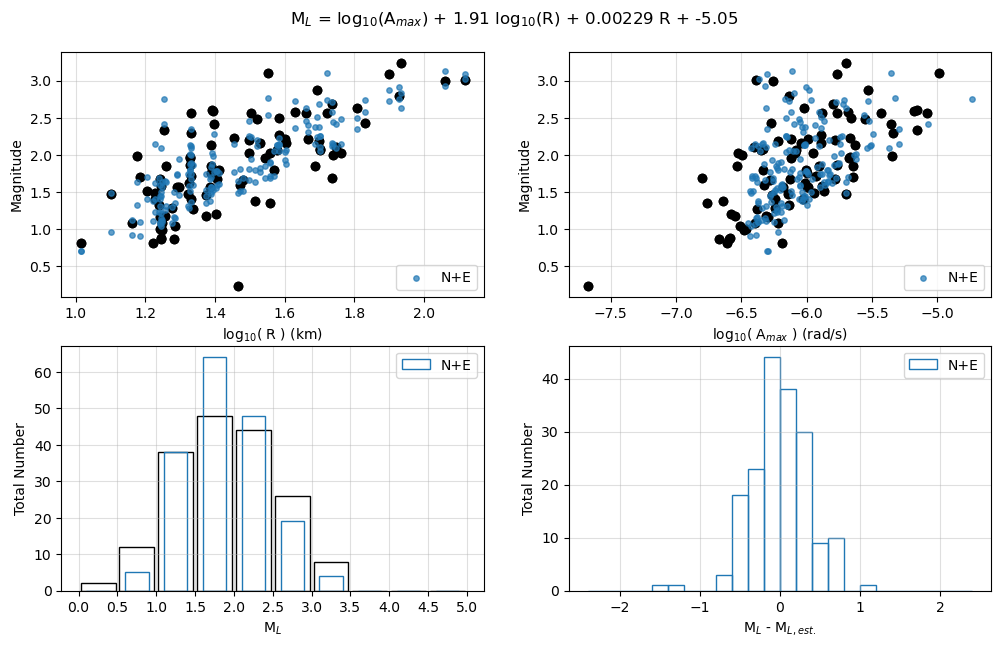

In [92]:
def __makeplot_magnitude_comparison4():

    fig, ax = plt.subplots(2,2, figsize=(12,7))

    ## ______________________________________________________________

    ax[0,0].scatter(np.log10(hdist), mag, color='k', zorder=3)
    ax[0,0].scatter(np.log10(hdist), syn_data, s=15, zorder=3, label="N+E", edgecolors="tab:blue", color="tab:blue", alpha=0.7)

    ax[0,0].grid(zorder=0, alpha=0.4)
    ax[0,0].legend(loc=4)

    ax[0,0].set_xlabel(r"log$_{10}$( R ) (km)")
    ax[0,0].set_ylabel("Magnitude")

    ## ______________________________________________________________

    ax[0,1].scatter(np.log10(amax_syn), mag, color='k', zorder=3)
    ax[0,1].scatter(np.log10(amax), syn_data, s=15, zorder=3, label="N+E", edgecolors="tab:blue", color="tab:blue", alpha=0.7)

    ax[0,1].grid(zorder=0, alpha=0.4)
    ax[0,1].legend(loc=4)

    ax[0,1].set_xlabel(r"log$_{10}$( A$_{max}$ ) (rad/s)")
    ax[0,1].set_ylabel("Magnitude")

    ## ______________________________________________________________

    dbars = 0.5
    bars = np.arange(0,5+dbars,dbars)

    # labels, counts = np.unique(mag, return_counts=True)
    # ax[1].bar(labels, counts, align='center', width=0.5)

    ax[1,0].hist(mag, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="k", rwidth=0.9, fill=False, align="mid")

    ax[1,0].hist(syn_data, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:blue", edgecolor="tab:blue", rwidth=0.6, fill=False, align="mid", label="N+E")

    ax[1,0].set_xticks(bars)

    ax[1,0].legend(loc=1)
    ax[1,0].grid(zorder=0, alpha=0.4)

    ax[1,0].set_xlabel(r"M$_L$")
    ax[1,0].set_ylabel("Total Number")


    ## ______________________________________________________________

    lim = round(max(max(abs(diff_z)), max(abs(diff_n)), max(abs(diff_e))),1)
    dbars2 = 0.2
    bars2 = np.arange(-lim, lim+dbars2, dbars2)

    ax[1,1].hist(diff_syn, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:blue", edgecolor="tab:blue", rwidth=1, fill=False, align="mid", label="N+E")


    ax[1,1].legend(loc=1)
    ax[1,1].grid(zorder=0, alpha=0.4)

    ax[1,1].set_xlabel(r"M$_L$ - M$_{L, est.}$")
    ax[1,1].set_ylabel("Total Number")

    ml_str, log10_str, amax_str = r"M$_L$", r"log$_{10}$", r"A$_{max}$"
    plt.suptitle(f" {ml_str} = {log10_str}({amax_str}) + {popt[0]:.2f} {log10_str}(R) + {popt[1]:.5f} R + {popt[2]:.2f}", y=0.94)

    plt.show();

__makeplot_magnitude_comparison4()

## Minimal Amplitude

In [154]:
min_amp_rot = 10e-7  # rad/s

a, b, c = 1.91, 0.00229, -5.05

hdist = np.arange(1, 200, 1)
mag = np.arange(0, 6.0, 0.1)

amax_syn = np.zeros((len(hdist), len(mag)))

for i, h in enumerate(hdist):
    for j, m in enumerate(mag):
        amax_syn[i,j] = __predict_local_amplitude((m, h), a, b, c)


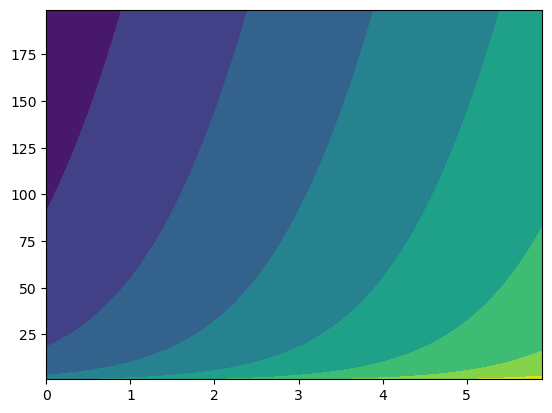

In [165]:
plt.contourf(mag, hdist, np.log10(amax_syn), cmap="viridis")
# plt.contour(mag, hdist, np.log10(amax_syn), cmap="viridis", zorder=3)

## Polar Plot

In [107]:
def __polar_plot(data1, data2):

    r1 = data1.Edistance_km
    r2 = data2.Edistance_km
    theta1 = np.radians(data1.BAZ)
    theta2 = np.radians(data2.BAZ)

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8,8))

    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)

    ax.scatter(theta2, r2, s=4**data2.Magnitude, c=data2.BSPF__E_amax ,lw=0.5, edgecolors="k", zorder=3)

    ## station
    ax.scatter(0, 0, zorder=3, s=100, marker='^', c="r", lw=0.8, edgecolors="k")

#     ax.set_rmax(2)

#     ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax.grid(True, zorder=0)

    ax.set_title("", va='bottom')
    plt.show()

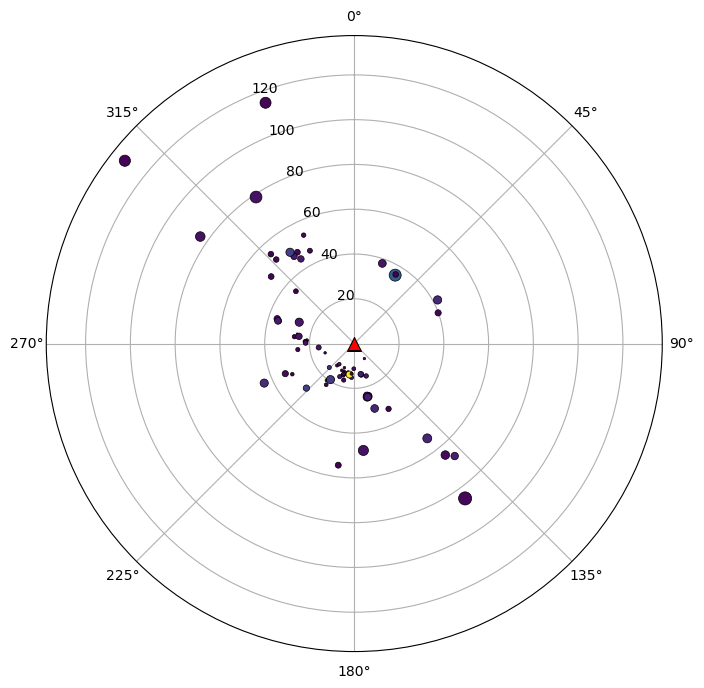

In [109]:
__polar_plot(data_amax_disp_cosum_6, data_amax_disp_cosum_6)

In [ ]:
data_baz = pd.read_pickle(config['path_to_data']+"bspf_baz_estimates.pkl")
data_baz_adr = pd.read_pickle(config['path_to_data']+"iadr_baz_estimates.pkl")

In [ ]:
x = np.arange(1,len(data_baz.event_time)+1)

plt.figure(figsize=(15,5))
plt.scatter(x, data_baz.baz_theo, c="k", zorder=3, label="Baz. theo.")

plt.scatter(x-0.1, data_baz.baz_mean, s=data_baz.samples+5, c="tab:red", zorder=3, edgecolors="k")
plt.errorbar(x-0.1, data_baz.baz_mean, yerr=data_baz.baz_std, ms=0, capsize=7, fmt="o", c="tab:red", zorder=2, label="Baz. mean (BSPF)")

plt.scatter(x+0.1, data_baz_adr.baz_mean, s=data_baz_adr.samples+5, c="tab:blue", zorder=3, edgecolors="k")
plt.errorbar(x+0.1, data_baz_adr.baz_mean, yerr=data_baz_adr.baz_std, ms=0, capsize=7, fmt="o", c="tab:blue", zorder=2, label="Baz. mean (ADR)")

plt.xlabel("Event No.")
plt.ylabel("Backazimuth (Â°)")
plt.legend(loc=3)
plt.grid(zorder=-1, axis="y")
plt.show();

In [ ]:
def __polar_plot2(data1):

    r1 = data1.edist_km

    theta1 = np.radians(data1.baz_mean)
    theta2 = np.radians(data1.baz_theo)

    err = data1.baz_std

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8,8))

    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)

    m1 = ax.scatter(theta1, r1, s=40, c="tab:red", marker="o", lw=0.5, edgecolors="k", zorder=3)
    m1.set_facecolor('none')

    ax.scatter(theta2, r1, s=40, c="darkgrey", lw=0.5, edgecolors="k", zorder=2)

    for i in range(len(r1)):
        ax.plot([theta1[i], theta2[i]], [r1[i], r1[i]], c="k", zorder=1, alpha=0.5, ls=":")

    # ax.bar(theta1, r1, width=err/200, bottom=0.0, color="b", alpha=0.5)
    ax.errorbar(theta1, r1, xerr=err/100, yerr=None, capsize=7, fmt="o", c="tab:red")

    ## station
    ax.scatter(0, 0, zorder=3, s=100, marker='^', c="r", lw=0.8, edgecolors="k")

#     ax.set_rmax(2)

#     ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax.grid(True, zorder=0)

    ax.set_title("", va='bottom')
    plt.show()

In [ ]:
__polar_plot2(data_baz)

In [ ]:
data_baz

## Amplitude Maxima

In [ ]:
def __makeplot_amax(data1, data2, xvalue):

    NJ = 4
    NI = 3

    fig, ax = plt.subplots(NJ, NI, figsize=(15,10))

    font = 14

    scale = 1
    msize = 12
    linew = 0.1

    ## _________________________

    ax[0,0].scatter(data1[xvalue], data1.PFO_10_Z_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[0,0].scatter(data2[xvalue], data2.PFO_10_Z_amax*scale, s=msize, color="red", label="XPFO Z", lw=linew, edgecolors="k")

    ax[0,1].scatter(data1[xvalue], data1.PFO_10_N_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[0,1].scatter(data2[xvalue], data2.PFO_10_N_amax*scale, s=msize, color="red", label="XPFO N", lw=linew, edgecolors="k")

    ax[0,2].scatter(data1[xvalue], data1.PFO_10_E_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[0,2].scatter(data2[xvalue], data2.PFO_10_E_amax*scale, s=msize, color="red", label="XPFO E", lw=linew, edgecolors="k")

    ## _________________________

    ax[1,0].scatter(data1[xvalue], data1.RPFO_al_Z_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[1,0].scatter(data2[xvalue], data2.RPFO_al_Z_amax*scale, s=msize, color="red", label="ADR all Z", lw=linew, edgecolors="k")

    ax[1,1].scatter(data1[xvalue], data1.RPFO_al_N_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[1,1].scatter(data2[xvalue], data2.RPFO_al_N_amax*scale, s=msize, color="red", label="ADR all N", lw=linew, edgecolors="k")

    ax[1,2].scatter(data1[xvalue], data1.RPFO_al_E_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[1,2].scatter(data2[xvalue], data2.RPFO_al_E_amax*scale, s=msize, color="red", label="ADR all E", lw=linew, edgecolors="k")

    ## _________________________

    ax[2,0].scatter(data1[xvalue], data1.RPFO_in_Z_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[2,0].scatter(data2[xvalue], data2.RPFO_in_Z_amax*scale, s=msize, color="red", label="ADR inner Z", lw=linew, edgecolors="k")

    ax[2,1].scatter(data1[xvalue], data1.RPFO_in_N_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[2,1].scatter(data2[xvalue], data2.RPFO_in_N_amax*scale, s=msize, color="red", label="ADR inner N", lw=linew, edgecolors="k")

    ax[2,2].scatter(data1[xvalue], data1.RPFO_in_E_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[2,2].scatter(data2[xvalue], data2.RPFO_in_E_amax*scale, s=msize, color="red", label="ADR inner E", lw=linew, edgecolors="k")

    ## _________________________

    ax[3,0].scatter(data1[xvalue], data1.BSPF__Z_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[3,0].scatter(data2[xvalue], data2.BSPF__Z_amax*scale, s=msize, color="red", label="BSPF Z", lw=linew, edgecolors="k")

    ax[3,1].scatter(data1[xvalue], data1.BSPF__N_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[3,1].scatter(data2[xvalue], data2.BSPF__N_amax*scale, s=msize, color="red", label="BSPF N", lw=linew, edgecolors="k")

    ax[3,2].scatter(data1[xvalue], data1.BSPF__E_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[3,2].scatter(data2[xvalue], data2.BSPF__E_amax*scale, s=msize, color="red", label="BSPF E", lw=linew, edgecolors="k")



    for i in range(NJ):
        for j in range(NI):
            ax[i,j].set_yscale("log")
            # ax[i,j].set_xscale("log")
            ax[i,j].legend(loc=4)
            ax[3,j].set_xlabel(xvalue, fontsize=font)
            ax[i,j].grid(ls="--", color="grey", alpha=0.6, zorder=0)

    ax[0,0].set_ylabel(r"Acc. (m/s$^2$)", fontsize=font)
    ax[1,0].set_ylabel(r"Rot. (rad/s)", fontsize=font)
    ax[2,0].set_ylabel(r"Rot. (rad/s)", fontsize=font)
    ax[3,0].set_ylabel(r"Rot. (rad/s)", fontsize=font)

    plt.show()

In [ ]:
__makeplot_amax(data_amax, data_amax_cosum_6, "Magnitude")

In [ ]:
def __makeplot_amax2(data1, data2, xvalue):

    NJ = 4
    NI = 3

    fig, ax = plt.subplots(NJ, NI, figsize=(15,10))

    font = 14

    scale = 1
    msize = 12
    linew = 0.1

    ## _________________________

    ax[0,0].scatter(data1[xvalue], data1.PFO_10_Z_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[0,0].scatter(data2[xvalue], data2.PFO_10_Z_amax*scale, s=msize, color="red", label="XPFO Z", lw=linew, edgecolors="k")

    ax[0,1].scatter(data1[xvalue], data1.PFO_10_N_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[0,1].scatter(data2[xvalue], data2.PFO_10_N_amax*scale, s=msize, color="red", label="XPFO N", lw=linew, edgecolors="k")

    ax[0,2].scatter(data1[xvalue], data1.PFO_10_E_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[0,2].scatter(data2[xvalue], data2.PFO_10_E_amax*scale, s=msize, color="red", label="XPFO E", lw=linew, edgecolors="k")

    ## _________________________

    ax[1,0].scatter(data1[xvalue], data1.RPFO_al_Z_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[1,0].scatter(data2[xvalue], data2.RPFO_al_Z_amax*scale, s=msize, color="red", label="ADR all Z", lw=linew, edgecolors="k")

    ax[1,1].scatter(data1[xvalue], data1.RPFO_al_N_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[1,1].scatter(data2[xvalue], data2.RPFO_al_N_amax*scale, s=msize, color="red", label="ADR all N", lw=linew, edgecolors="k")

    ax[1,2].scatter(data1[xvalue], data1.RPFO_al_E_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[1,2].scatter(data2[xvalue], data2.RPFO_al_E_amax*scale, s=msize, color="red", label="ADR all E", lw=linew, edgecolors="k")

    ## _________________________

    ax[2,0].scatter(data1[xvalue], data1.RPFO_in_Z_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[2,0].scatter(data2[xvalue], data2.RPFO_in_Z_amax*scale, s=msize, color="red", label="ADR inner Z", lw=linew, edgecolors="k")

    ax[2,1].scatter(data1[xvalue], data1.RPFO_in_N_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[2,1].scatter(data2[xvalue], data2.RPFO_in_N_amax*scale, s=msize, color="red", label="ADR inner N", lw=linew, edgecolors="k")

    ax[2,2].scatter(data1[xvalue], data1.RPFO_in_E_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[2,2].scatter(data2[xvalue], data2.RPFO_in_E_amax*scale, s=msize, color="red", label="ADR inner E", lw=linew, edgecolors="k")

    ## _________________________

    ax[3,0].scatter(data1[xvalue], data1.BSPF__Z_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[3,0].scatter(data2[xvalue], data2.BSPF__Z_amax*scale, s=msize, color="red", label="BSPF Z", lw=linew, edgecolors="k")

    ax[3,1].scatter(data1[xvalue], data1.BSPF__N_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[3,1].scatter(data2[xvalue], data2.BSPF__N_amax*scale, s=msize, color="red", label="BSPF N", lw=linew, edgecolors="k")

    ax[3,2].scatter(data1[xvalue], data1.BSPF__E_amax*scale, s=msize, color="grey", alpha=0.7)
    ax[3,2].scatter(data2[xvalue], data2.BSPF__E_amax*scale, s=msize, color="red", label="BSPF E", lw=linew, edgecolors="k")


    # for j in range(1,3):
    #     ax[j,0].set_ylim(1e-9, 1e-5)
    #     ax[j,1].set_ylim(1e-9, 1e-5)
    #     ax[j,2].set_ylim(1e-9, 1e-5)

    for i in range(NJ):
        for j in range(NI):
            ax[i,j].set_yscale("log")
            ax[i,j].set_xscale("log")
            ax[i,j].legend(loc=1)
            ax[3,j].set_xlabel("Hypocenter Distance (km)", fontsize=font)
#             ax[i,j].grid(ls="--", color="grey", alpha=0.6, zorder=0, which="both")
            ax[i,j].set_xlim(left=10)

    ax[0,0].set_ylabel(r"Acc. (m/s$^2$)", fontsize=font)
    ax[1,0].set_ylabel(r"Rot. (rad/s)", fontsize=font)
    ax[2,0].set_ylabel(r"Rot. (rad/s)", fontsize=font)
    ax[3,0].set_ylabel(r"Rot. (rad/s)", fontsize=font)

    plt.show()

In [ ]:
__makeplot_amax2(data_amax, data_amax_cosum_6, "Hdistance")

## Compare ADR - BSPF maximal amplitudes

In [ ]:
def __makeplot_compare_amax(data1, data2):

    NJ = 2
    NI = 3

    fig, ax = plt.subplots(NJ, NI, figsize=(15,10))

    font = 14
    scale = 1
    msize = 12
    linew = 0.1




    ## _________________________

    ax[0,0].plot(data1.BSPF_i_Z_adr, data1.BSPF_i_Z_adr, ls=":", c="k")
    ax[0,1].plot(data1.BSPF_i_N_adr, data1.BSPF_i_N_adr, ls=":", c="k")
    ax[0,2].plot(data1.BSPF_i_E_adr, data1.BSPF_i_E_adr, ls=":", c="k")

    # ax[0,0].plot(data1.BSPF_i_Z_adr, data1.BSPF_i_Z_adr*1e-2, ls=":", c="b")
    # ax[0,1].plot(data1.BSPF_i_N_adr, data1.BSPF_i_N_adr*1e-2, ls=":", c="b")
    # ax[0,2].plot(data1.BSPF_i_E_adr, data1.BSPF_i_E_adr*1e-2, ls=":", c="b")

    ax[0,0].scatter(data1.BSPF_i_Z_adr, data1.RPFO_in_Z_adr, s=msize, color="grey", alpha=1, zorder=2)
    ax[0,0].scatter(data2.BSPF_i_Z_adr, data2.RPFO_in_Z_adr, s=msize, color="tab:red", label="RPFO inner Z", lw=linew, edgecolors="k", zorder=3)

    ax[0,1].scatter(data1.BSPF_i_N_adr, data1.RPFO_in_N_adr, s=msize, color="grey", alpha=1, zorder=2)
    ax[0,1].scatter(data2.BSPF_i_N_adr, data2.RPFO_in_N_adr, s=msize, color="tab:red", label="RPFO inner N", lw=linew, edgecolors="k", zorder=3)

    ax[0,2].scatter(data1.BSPF_i_E_adr, data1.RPFO_in_E_adr, s=msize, color="grey", alpha=1, zorder=2)
    ax[0,2].scatter(data2.BSPF_i_E_adr, data2.RPFO_in_E_adr, s=msize, color="tab:red", label="RPFO inner E", lw=linew, edgecolors="k", zorder=3)

    ## _________________________

    ax[1,0].plot(data1.BSPF_a_Z_adr, data1.BSPF_a_Z_adr, ls=":", c="k")
    ax[1,1].plot(data1.BSPF_a_N_adr, data1.BSPF_a_N_adr, ls=":", c="k")
    ax[1,2].plot(data1.BSPF_a_E_adr, data1.BSPF_a_E_adr, ls=":", c="k")

    ax[1,0].scatter(data1.BSPF_a_Z_adr, data1.RPFO_al_Z_adr, s=msize, color="grey", alpha=1, zorder=2)
    ax[1,0].scatter(data2.BSPF_a_Z_adr, data2.RPFO_al_Z_adr, s=msize, color="tab:red", label="ADR all Z", lw=linew, edgecolors="k", zorder=3)

    ax[1,1].scatter(data1.BSPF_a_N_adr, data1.RPFO_al_N_adr, s=msize, color="grey", alpha=1, zorder=2)
    ax[1,1].scatter(data2.BSPF_a_N_adr, data2.RPFO_al_N_adr, s=msize, color="tab:red", label="ADR all N", lw=linew, edgecolors="k", zorder=3)

    ax[1,2].scatter(data1.BSPF_a_E_adr, data1.RPFO_al_E_adr, s=msize, color="grey", alpha=1, zorder=2)
    ax[1,2].scatter(data2.BSPF_a_E_adr, data2.RPFO_al_E_adr, s=msize, color="tab:red", label="ADR all E", lw=linew, edgecolors="k", zorder=3)


    for i in range(NJ):
        for j in range(NI):
            ax[i,j].set_yscale("log")
            ax[i,j].set_xscale("log")
            ax[1,j].set_xlabel(r"BSPF (rad/s)", fontsize=font)

            ax[i,j].legend(loc=2)
            ax[i,j].grid(ls="-", color="lightgrey", alpha=0.6, zorder=0, which="both")

    for j in range(3):
#         ax[0,j].set_title(f"0.16-16.5 Hz")
#         ax[1,j].set_title(f"0.02-1.3 Hz")
        ax[0,j].set_title("5.0-16.0 Hz")
        ax[1,j].set_title("0.5-1.0 Hz")

        ax[0,j].set_xlim(right=max([max(data1.BSPF_i_E_adr), max(data1.BSPF_i_N_adr), max(data1.BSPF_i_Z_adr)])*1.8)
        ax[1,j].set_xlim(right=max([max(data1.BSPF_a_E_adr), max(data1.BSPF_a_N_adr), max(data1.BSPF_a_Z_adr)])*1.8)
        ax[0,j].set_xlim(left=min([min(data1.BSPF_i_E_adr), min(data1.BSPF_i_N_adr), min(data1.BSPF_i_Z_adr)])*0.8)
        ax[1,j].set_xlim(left=min([min(data1.BSPF_a_E_adr), min(data1.BSPF_a_N_adr), min(data1.BSPF_a_Z_adr)])*0.8)

    ax[0,0].set_ylabel(r"RPFO inner (rad/s)", fontsize=font)
    ax[1,0].set_ylabel(r"RPFO all (rad/s)", fontsize=font)

    plt.show()

In [ ]:
__makeplot_compare_amax(data_adr, data_adr_cosum_6)

## Signal-to-Noise Ratio

In [ ]:
def __makeplot_snr(data1, data2, xvalue):

    NJ = 4
    NI = 3

    fig, ax = plt.subplots(NJ, NI, figsize=(15,10))

    font = 14
    scale = 1e0
    msize = 12

    ## _________________________

    ax[0,0].scatter(data1[xvalue], data1.PFO_10_Z_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[0,0].scatter(data2[xvalue], data2.PFO_10_Z_snr*scale, s=msize, label="XPFO Z")

    ax[0,1].scatter(data1[xvalue], data1.PFO_10_N_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[0,1].scatter(data2[xvalue], data2.PFO_10_N_snr*scale, s=msize, label="XPFO N")

    ax[0,2].scatter(data1[xvalue], data1.PFO_10_E_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[0,2].scatter(data2[xvalue], data2.PFO_10_E_snr*scale, s=msize, label="XPFO E")

    ## _________________________

    ax[1,0].scatter(data1[xvalue], data1.RPFO_al_Z_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[1,0].scatter(data2[xvalue], data2.RPFO_al_Z_snr*scale, s=msize, label="ADR all Z")

    ax[1,1].scatter(data1[xvalue], data1.RPFO_al_N_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[1,1].scatter(data2[xvalue], data2.RPFO_al_N_snr*scale, s=msize, label="ADR all N")

    ax[1,2].scatter(data1[xvalue], data1.RPFO_al_E_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[1,2].scatter(data2[xvalue], data2.RPFO_al_E_snr*scale, s=msize, label="ADR all E")

    ## _________________________

    ax[2,0].scatter(data1[xvalue], data1.RPFO_in_Z_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[2,0].scatter(data2[xvalue], data2.RPFO_in_Z_snr*scale, s=msize, label="ADR inner Z")

    ax[2,1].scatter(data1[xvalue], data1.RPFO_in_N_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[2,1].scatter(data2[xvalue], data2.RPFO_in_N_snr*scale, s=msize, label="ADR inner N")

    ax[2,2].scatter(data1[xvalue], data1.RPFO_in_E_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[2,2].scatter(data2[xvalue], data2.RPFO_in_E_snr*scale, s=msize, label="ADR inner E")

    ## _________________________

    ax[3,0].scatter(data1[xvalue], data1.BSPF__Z_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[3,0].scatter(data2[xvalue], data2.BSPF__Z_snr*scale, s=msize, label="BSPF Z")

    ax[3,1].scatter(data1[xvalue], data1.BSPF__N_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[3,1].scatter(data2[xvalue], data2.BSPF__N_snr*scale, s=msize, label="BSPF N")

    ax[3,2].scatter(data1[xvalue], data1.BSPF__E_snr*scale, s=msize, color="grey", alpha=0.7)
    ax[3,2].scatter(data2[xvalue], data2.BSPF__E_snr*scale, s=msize, label="BSPF E")


    for i in range(NJ):
        for j in range(NI):
            ax[i,j].set_yscale("log")
            # ax[i,j].set_xscale("log")
            ax[i,j].legend(loc=2)
            ax[3,j].set_xlabel(xvalue, fontsize=font)
            ax[i,j].set_ylim(1e-1, 1e4)
            ax[i,j].grid(ls="--", color="grey", alpha=0.6, zorder=0)

    ax[0,0].set_ylabel(r"SNR", fontsize=font)
    ax[1,0].set_ylabel(r"SNR", fontsize=font)
    ax[2,0].set_ylabel(r"SNR", fontsize=font)
    ax[3,0].set_ylabel(r"SNR", fontsize=font)

    plt.show()

In [ ]:
__makeplot_snr(data_snr, data_snr_cosum_6, "Magnitude")

In [ ]:
__makeplot_snr(data_snr, data_snr_cosum_6, "Hdistance")

## Velocity

In [ ]:
def __makeplot_velocity(data):

    from numpy import array, log10

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    font = 14

    scale = 1e3
    msize = 10
    linew = 0.3

    data0 = data.dropna()

    x_arr1 = data0.BSPF__Z_amax*scale
    y_arr1= 0.5*data0.PFO_10_T_amax*scale

    xx1 = array([b for a, b in zip(y_arr1, x_arr1) if a/b > 1e-3])
    yy1 = array([a for a, b in zip(y_arr1, x_arr1) if a/b > 1e-3])

#     xx1, yy1 = log10(xx1), log10(yy1)

    x_axis1 = np.linspace(0, xx1.max(), 100)


    ## linear regression
#     b1, a1 = __compute_orthogonal_distance_regression(xx1, yy1, xerr=None, yerr=None, bx=None, by=None)
    b1, a1 = __compute_linear_regression(xx1, yy1, intercept_is_zero=True)

    ax[0].scatter(xx1, yy1, s=20, c='r', marker="o", label=f"N={len(xx1)}", zorder=3, lw=linew, edgecolors="k")
    ax[0].plot(x_axis1, a1+b1*x_axis1, color='k', ls="--", label=f"f(x) = {a1:.0f} + {b1:.0f} x", zorder=1)

    ax[0].legend(loc=2, fontsize=font)
    ax[0].grid(ls="--", color="grey", alpha=0.6, zorder=0)

    ax[0].set_xlim(left=0)
    ax[0].set_ylim(bottom=0)

    ax[0].set_xlabel("vertical rotation rate $\Omega_Z$ (mrad/s)", fontsize=font)
    ax[0].set_ylabel("transverse acceleration $a_T$ (mm/s$^2$)", fontsize=font)
    ax[0].set_title("Love Phase Velocity", fontsize=font+1)


    ## ______________________________________________

    x_arr2 = data0.BSPF__T_amax*scale
    y_arr2= data0.PFO_10_Z_amax*scale

    xx2 = array([b for a, b in zip(y_arr2, x_arr2) if a/b > 1e-3])
    yy2 = array([a for a, b in zip(y_arr2, x_arr2) if a/b > 1e-3])

#     xx2, yy2 = log10(xx2), log10(yy2)

    x_axis2 = np.linspace(0, xx2.max(), 100)

    ## linear regression
#     b2, a2 = __compute_orthogonal_distance_regression(xx2, yy2, xerr=None, yerr=None, bx=None, by=None)
    b2, a2 = __compute_linear_regression(xx2, yy2, intercept_is_zero=True)

    ax[1].scatter(xx2, yy2, s=20, c='r' ,marker="o", label=f"N={len(xx2)}", zorder=3, lw=linew, edgecolors="k")
    ax[1].plot(x_axis2, a2+b2*x_axis2, color='k', ls="--", label=f"f(x) = {a2:.0f} + {b2:.0f} x", zorder=1)

    ax[1].legend(loc=2, fontsize=font)
    ax[1].grid(ls="--", color="grey", alpha=0.6, zorder=0)

    ax[1].set_xlim(left=0)
    ax[1].set_ylim(bottom=0)

    ax[1].set_xlabel("transverse rotation rate $\Omega_T$ (mrad/s)", fontsize=font)
    ax[1].set_ylabel("vertical acceleration $a_Z$ (mm/s$^2$)", fontsize=font)
    ax[1].set_title("Rayleigh Phase Velocity", fontsize=font+1)

    plt.show();

__makeplot_velocity(data_amax)